In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nbeats_keras.model import NBeatsNet as NBeatsKeras
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
#from nbeats_pytorch.model import NBeatsNet as NBeatsPytorch
from keras.optimizers import RMSprop, Adam
import time
from keras.models import load_model
#from target_data_electronic70_7 import target_X, target_y ,test_X, test_y
#from m4databasis21_7 import base_domain,zt_in,zt_out,M4Meta,inputsize,train_12,train_12_y
from sklearn.metrics import mean_squared_error,mean_absolute_error,mean_absolute_percentage_error
from tensorflow.keras.losses import Loss
import tensorflow as tf
#from m4databasis35_7_70_7 import train_35,train_35_y,train_70,train_70_y
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LayerNormalization, MultiHeadAttention, Dropout, Add, Concatenate,Flatten,Reshape
#import pandas as pd
target_X= pd.read_csv("../data/tem_train_input_7.csv").iloc[:,1:].values.astype(np.float32)
target_y =pd.read_csv("../data/tem_train_output_7.csv").iloc[:,1:].values.astype(np.float32)
test_X= pd.read_csv("../data/tem_val_input_7.csv").iloc[:,1:].values.astype(np.float32)
test_y =pd.read_csv("../data/tem_val_output_7.csv").iloc[:,1:].values.astype(np.float32)

X_train=target_X.astype(np.float32)
y_train=target_y.astype(np.float32)
#y_train.astype(np.float32)
backcast_length = X_train.shape[1]
forecast_length = y_train.shape[1]

2024-10-09 02:58:12.819700: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-09 02:58:12.896785: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-10-09 02:58:12.896802: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-10-09 02:58:13.248664: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-

In [2]:
X_train.shape,y_train.shape

((723, 168), (723, 24))

# 함수

In [3]:
#################################################################################
# loss SMAPE
class SMAPE(Loss):
    def call(self, y_true, y_pred):
        y_pred = tf.reshape(y_pred, tf.shape(y_true))  # 예측 값의 차원을 맞춤
       # y_pred=tf.clip_by_value(y_pred, 1e-10, tf.reduce_max(y_pred))
       # y_true = tf.clip_by_value(y_true, 1e-10, tf.reduce_max(y_true))
        
        numerator = 100 * tf.abs(y_true- y_pred )
        denominator =  (tf.abs(y_true ) + tf.abs(y_pred))/2
        smape =  numerator /  denominator #tf.clip_by_value(denominator, 1e-10, tf.reduce_max(denominator))
        return tf.reduce_mean(smape)

#################################################################################
# loss MASE
class MASE(Loss):
    def __init__(self, training_data, period, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.scale = self.calculate_scale(training_data, period)
    def seasonal_diff(data, period):
        return data[period:] - data[:-period]

    def calculate_scale(self, training_data, period):
        # 주기 차분 계산
        diff = seasonal_diff(training_data, period)
        scale = np.mean(np.abs(diff))
        return scale
    
    def call(self, y_true, y_pred):
        y_pred = tf.reshape(y_pred, tf.shape(y_true))  # 차원 맞추기
        error = tf.abs(y_true - y_pred)
        return tf.reduce_mean(error / self.scale)

def seasonal_diff(data, period):
    return data[period:] - data[:-period]

#################################################################################
#################################################################################
# 하이퍼파라미터 인자 설정
def hyperparameter():
    # 1 backcast
    # 2 forecast
    # 3 inputdim
    # 4 outputdim
    # 5 unit
    # 6 bacth size
    return X_train.shape[1],y_train.shape[1],1,1,256

#################################################################################
# nbeats + I모델 생성 함수
def bulid_model(backcast_,forecast_,input_dim,output_dim,unit):
    model= NBeatsKeras(backcast_length=backcast_, 
                       forecast_length=forecast_,
                       input_dim=input_dim,
                       output_dim=output_dim,
                       stack_types=(NBeatsKeras.TREND_BLOCK,
                                    NBeatsKeras.TREND_BLOCK,
                                    
                                    NBeatsKeras.TREND_BLOCK,
                                    NBeatsKeras.SEASONALITY_BLOCK,
                                    NBeatsKeras.SEASONALITY_BLOCK,
                                    NBeatsKeras.SEASONALITY_BLOCK)
                   ,nb_blocks_per_stack=1, thetas_dim=(1,2,3,24,12,6),
                   share_weights_in_stack=True, hidden_layer_units=unit)
    return model 
#################################################################################
# nbeats + G모델 생성 함수    
def bulid_model_G(backcast_,forecast_,input_dim,output_dim,unit):
    model= NBeatsKeras(backcast_length=backcast_, 
                       forecast_length=forecast_,
                       input_dim=input_dim,
                       output_dim=output_dim,
                       stack_types=(NBeatsKeras.GENERIC_BLOCK,NBeatsKeras.GENERIC_BLOCK)
                   ,nb_blocks_per_stack=5, thetas_dim=(24,24),
                   share_weights_in_stack=False, hidden_layer_units=unit)
    return model 
#################################################################################
# nbeats + I모델 부트스트랩 샘플링 배깅

def train_bagging_models(num_models, loss_fn , epochs_, patience_,batch_size_,lr):
    models = {}
    backcast,forecast,in_dim,out_dim,unit = hyperparameter()
    historys = []
    for n in range(num_models):
        K.clear_session()
        model = bulid_model(backcast,forecast,in_dim,out_dim,unit)
       # model.set_weights(pretrained_weights)  # 전이 학습 가중치 적용
        optimizer = Adam(learning_rate=lr)
        model.compile(optimizer=optimizer , loss=loss_fn)
        
        # 부트스트랩 샘플링
        #select = np.random.choice(len(X_train), size=len(X_train), replace=True)
        #X_bootstrap = X_train[select]
        #y_bootstrap = y_train[select]
        early_stop = EarlyStopping(monitor='val_loss', patience = patience_, verbose = 0, restore_best_weights=True)
        history = model.fit(X_train, y_train, batch_size = batch_size_,
                  epochs=epochs_, verbose=1, 
                  callbacks=[early_stop],
                 validation_split = 0.2)
        models[f'model_{n+1}'] = model
        historys.append(history)
        #models.append(model)
        print(f"'########################################################Model{n}")
    return models,historys
#################################################################################
# nbeats + I모델 부트스트랩 샘플링 배깅

def train_bagging_models_G(num_models, loss_fn , epochs_, patience_,batch_size_,lr):
    models = {}
    backcast,forecast,in_dim,out_dim,unit = hyperparameter()
    historys = []
    for n in range(num_models):
        K.clear_session()
        model = bulid_model_G(backcast,forecast,in_dim,out_dim,unit)
       # model.set_weights(pretrained_weights)  # 전이 학습 가중치 적용
        optimizer = Adam(learning_rate=lr)
        model.compile(optimizer=optimizer , loss=loss_fn)
        
        # 부트스트랩 샘플링
        #select = np.random.choice(len(X_train), size=len(X_train), replace=True)
        #X_bootstrap = X_train[select]
        #y_bootstrap = y_train[select]
        early_stop = EarlyStopping(monitor='val_loss', patience = patience_, verbose = 0, restore_best_weights=True)
        history = model.fit(X_train, y_train, batch_size = batch_size_,
                  epochs=epochs_, verbose=0, 
                  callbacks=[early_stop],
                 validation_split = 0.2)
        models[f'model_{n+1}'] = model
        historys.append(history)
        #models.append(model)
        print(f"'########################################################Model{n}")
    return models,historys

#################################################################################
# SMAPE 용
def train_bagging_models_smape(num_models, loss_fn , epochs_, patience_,batch_size_,lr):
    models = {}
    backcast,forecast,in_dim,out_dim,unit = hyperparameter()
    historys = []
    for n in range(num_models):
        K.clear_session()
        model = bulid_model(backcast,forecast,in_dim,out_dim,unit)
       # model.set_weights(pretrained_weights)  # 전이 학습 가중치 적용
        optimizer = Adam(learning_rate=lr)
        model.compile(optimizer=optimizer , loss=loss_fn)
        
        # 부트스트랩 샘플링
        #select = np.random.choice(len(X_train), size=len(X_train), replace=True)
        #X_bootstrap = X_train[select]
        #y_bootstrap = y_train[select]
        early_stop = EarlyStopping(monitor='val_loss', patience = patience_, verbose = 0, restore_best_weights=True)
        history = model.fit(X_bootstrap, y_bootstrap, batch_size = batch_size_,
                  epochs=epochs_, verbose=1, 
                  callbacks=[early_stop],
                 validation_split = 0.2)
        models[f'model_{n+1}'] = model
        historys.append(history)
        #models.append(model)
        print(f"'########################################################Model{n}")
    return models,historys

##########################################################################################
# 트랜스퍼 레이어
class PositionalEncoding(layers.Layer):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = layers.Dropout(rate=dropout)

        position = np.arange(max_len)[:, np.newaxis]
        div_term = np.exp(np.arange(0, d_model, 2) * (-np.log(10000.0) / d_model))
        pe = np.zeros((max_len, d_model))
        pe[:, 0::2] = np.sin(position * div_term)
        pe[:, 1::2] = np.cos(position * div_term)
        pe = pe[np.newaxis, ...]

        self.pe = tf.constant(pe, dtype=tf.float32)

    def call(self, x):
        x = x + self.pe[:, :tf.shape(x)[1], :]
        return self.dropout(x)
##########################################################################################
# 트랜스퍼 레이어
def create_model(fn,d_model, nlayers, nhead, dropout, iw, ow,lr):
    
    
    x = layers.Dense(d_model // 2, activation='relu')(pretrained_output_reshaped)
    x = layers.Dense(d_model, activation='relu')(x)
    
    pos_encoding = PositionalEncoding(d_model, dropout)
    x = pos_encoding(x)
    
    for _ in range(nlayers):
        attn_output = layers.MultiHeadAttention(num_heads=nhead, key_dim=d_model, dropout=dropout)(x, x)
        x = layers.LayerNormalization(epsilon=1e-6)(x + attn_output)
        ffn_output = layers.Dense(d_model, activation='relu')(x)
        ffn_output = layers.Dense(d_model)(ffn_output)
        x = layers.LayerNormalization(epsilon=1e-6)(x + ffn_output)
    
    x = layers.Dense(d_model // 2, activation='relu')(x)
    x = layers.Dense(1)(x)
    x = tf.squeeze(x, axis=-1)
    
    outputs = layers.Dense((iw + ow) // 2, activation='relu')(x)
    outputs = layers.Dense(ow)(outputs)
    
    optimizer = Adam(learning_rate=lr)
    target_model = Model(inputs=inputs, outputs=outputs)
    target_model.compile(optimizer=optimizer, loss=fn)
    
    return target_model
#################################################################################
# 예측

def bagging_predict(models, X):
    predictions = np.array([model.predict(X) for model in models.values()])
    return np.median(predictions, axis=0)

def bagging_predict2(models, X):
    predictions = np.array([model.predict(X) for model in models.values()])
    return predictions

# 모형적합

In [4]:
model_num = 5

mase_models = train_bagging_models(model_num, MASE(y_train,24),2000,10,8,0.001)
mape_models = train_bagging_models(model_num,'mape',2000,10,8,0.001)
smape_models = train_bagging_models(model_num, SMAPE(),2000,10,8,0.001)
mae_models = train_bagging_models(model_num,'mae',2000,10,8,0.001)
mse_models = train_bagging_models(model_num, 'mse',2000,10,8,0.001)

2024-10-09 02:58:38.505338: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-10-09 02:58:38.505387: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ymlee2-desktop): /proc/driver/nvidia/version does not exist
2024-10-09 02:58:38.506045: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/2000
73/73 [==============================] - 2s 10ms/step - loss: 0.9361 - val_loss: 0.4581
Epoch 2/2000
73/73 [==============================] - 0s 6ms/step - loss: 0.4287 - val_loss: 0.4233
Epoch 3/2000
73/73 [==============================] - 0s 6ms/step - loss: 0.3823 - val_loss: 0.4066
Epoch 4/2000
73/73 [==============================] - 0s 6ms/step - loss: 0.3591 - val_loss: 0.4210
Epoch 5/2000
73/73 [==============================] - 0s 6ms/step - loss: 0.3444 - val_loss: 0.3916
Epoch 6/2000
73/73 [==============================] - 0s 6ms/step - loss: 0.3173 - val_loss: 0.3900
Epoch 7/2000
73/73 [==============================] - 0s 6ms/step - loss: 0.3181 - val_loss: 0.3864
Epoch 8/2000
73/73 [==============================] - 0s 6ms/step - loss: 0.3030 - val_loss: 0.3664
Epoch 9/2000
73/73 [==============================] - 0s 6ms/step - loss: 0.2961 - val_loss: 0.3897
Epoch 10/2000
73/73 [==============================] - 0s 6ms/step - loss: 0.3005 - val_loss: 0.377

12/12 [==============================] - 0s 2ms/step


(2.656694, 1.8626094)

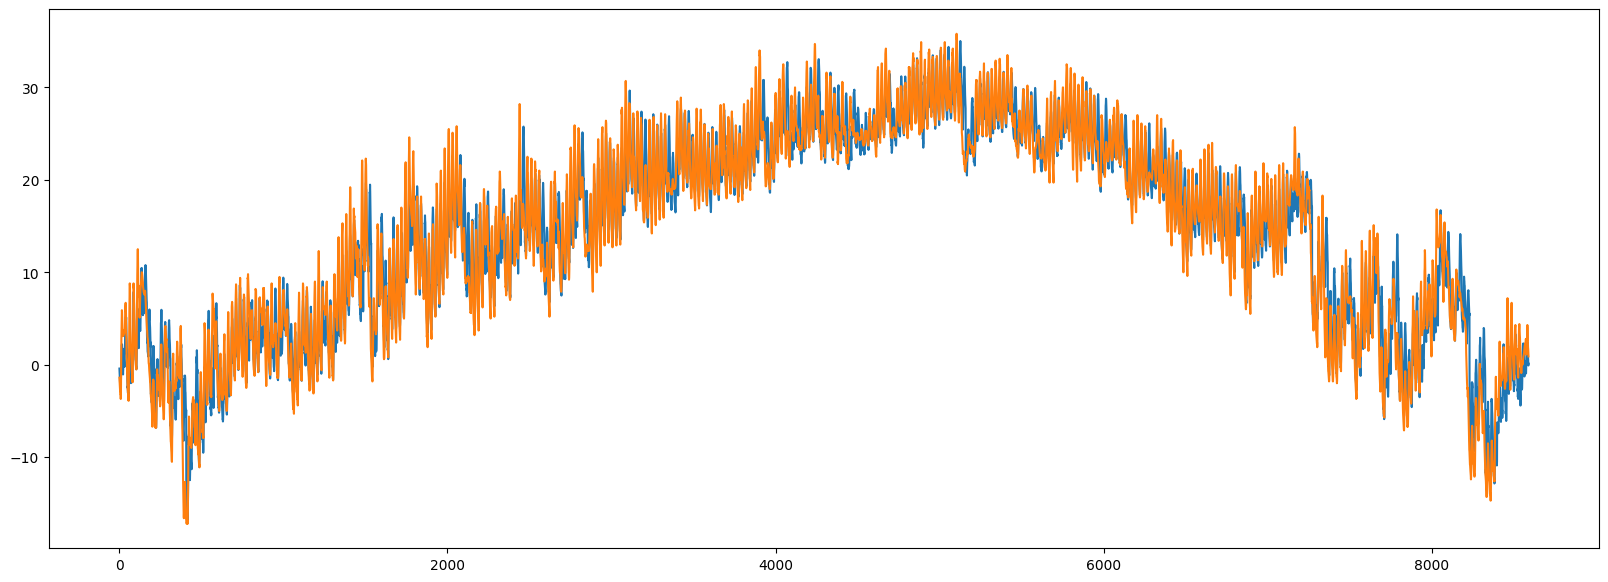

In [5]:
pred1,_=smape_models
pred2,_=mase_models
pred3,_=mape_models
pred4,_=mae_models
pred5,_=mse_models

smape_predictions = bagging_predict2(pred1, test_X)
mase_predictions = bagging_predict2(pred2, test_X)
mape_predictions = bagging_predict2(pred3, test_X)
mae_predictions = bagging_predict2(pred4, test_X)
mse_predictions = bagging_predict2(pred5, test_X)

concat_I = np.concatenate([smape_predictions, mase_predictions,mape_predictions,mae_predictions,mse_predictions],axis=0)
fin_pred_I = np.median(concat_I,axis=0)
#pd.DataFrame(fin_pred).to_csv("freezing_I.csv")
plt.figure(figsize=(20,7))
plt.plot(fin_pred_I.flatten())
plt.plot(test_y.flatten())
np.sqrt(mean_squared_error(test_y.flatten(),fin_pred_I.flatten())),mean_absolute_error(test_y.flatten(),fin_pred_I.flatten())


In [26]:
concat_I = np.concatenate([smape_predictions, mase_predictions,mape_predictions,mae_predictions,mse_predictions],axis=0)
fin_pred_I = np.median(concat_I,axis=0)
pd.DataFrame(fin_pred_I.flatten()).to_csv("../result7/NBEATs+I.csv")
np.sqrt(mean_squared_error(test_y.flatten(),fin_pred_I.flatten())),mean_absolute_error(test_y.flatten(),fin_pred_I.flatten())

(2.656694, 1.8626094)

In [28]:
concat_I = np.concatenate([mase_predictions, mae_predictions,mse_predictions],axis=0)
pd.DataFrame(fin_pred_I.flatten()).to_csv("../best7/NBEATs+I.csv")

fin_pred_I = np.median(concat_I,axis=0)
np.sqrt(mean_squared_error(test_y.flatten(),fin_pred_I.flatten())),mean_absolute_error(test_y.flatten(),fin_pred_I.flatten())

(2.6769645, 1.8611926)

In [6]:
concat_I = np.concatenate([smape_predictions, mase_predictions,mape_predictions],axis=0)
fin_pred_I = np.median(concat_I,axis=0)
np.sqrt(mean_squared_error(test_y.flatten(),fin_pred_I.flatten())),mean_absolute_error(test_y.flatten(),fin_pred_I.flatten())

(2.6669233, 1.8893291)

In [7]:
concat_I = np.concatenate([smape_predictions],axis=0)
fin_pred_I = np.median(concat_I,axis=0)
#pd.DataFrame(fin_pred).to_csv("freezing_I.csv")
np.sqrt(mean_squared_error(test_y.flatten(),fin_pred_I.flatten())),mean_absolute_error(test_y.flatten(),fin_pred_I.flatten())

(2.7081428, 1.8905839)

In [8]:
concat_I = np.concatenate([mape_predictions],axis=0)
fin_pred_I = np.median(concat_I,axis=0)
#pd.DataFrame(fin_pred).to_csv("freezing_I.csv")
np.sqrt(mean_squared_error(test_y.flatten(),fin_pred_I.flatten())),mean_absolute_error(test_y.flatten(),fin_pred_I.flatten())

(5.0212164, 3.9074326)

In [9]:
concat_I = np.concatenate([mase_predictions],axis=0)
fin_pred_I = np.median(concat_I,axis=0)
#pd.DataFrame(fin_pred).to_csv("freezing_I.csv")
np.sqrt(mean_squared_error(test_y.flatten(),fin_pred_I.flatten())),mean_absolute_error(test_y.flatten(),fin_pred_I.flatten())

(2.7291715, 1.9044933)

In [10]:
concat_I = np.concatenate([mae_predictions],axis=0)
fin_pred_I = np.median(concat_I,axis=0)
#pd.DataFrame(fin_pred).to_csv("freezing_I.csv")
np.sqrt(mean_squared_error(test_y.flatten(),fin_pred_I.flatten())),mean_absolute_error(test_y.flatten(),fin_pred_I.flatten())

(2.7313566, 1.8788493)

In [11]:
concat_I = np.concatenate([mse_predictions],axis=0)
fin_pred_I = np.median(concat_I,axis=0)
#pd.DataFrame(fin_pred).to_csv("freezing_I.csv")
np.sqrt(mean_squared_error(test_y.flatten(),fin_pred_I.flatten())),mean_absolute_error(test_y.flatten(),fin_pred_I.flatten())

(2.7429264, 1.9694629)

In [12]:
pd.DataFrame(fin_pred_I.reshape(-1,24)).to_csv("../result7_new/NBEATs_B/pred_mid_I.csv")
for i in range(10):
    pd.DataFrame(concat_I[i].reshape(-1,24)).to_csv(f"../result7_new/NBEATs_B/pred_I{i}.csv")

# 일반블락

In [13]:
model_num = 5

mase_models_G = train_bagging_models_G(model_num, MASE(y_train,24),2000,10,8,0.001)
mape_models_G = train_bagging_models_G(model_num,'mape',2000,10,8,0.001)
smape_models_G = train_bagging_models_G(model_num, SMAPE(),2000,10,8,0.001)
mae_models_G = train_bagging_models_G(model_num,'mae',2000,10,8,0.001)
mse_models_G = train_bagging_models_G(model_num, 'mse',2000,10,8,0.001)

'########################################################Model0
'########################################################Model1
'########################################################Model2
'########################################################Model3
'########################################################Model4
'########################################################Model0
'########################################################Model1
'########################################################Model2
'########################################################Model3
'########################################################Model4
'########################################################Model0
'########################################################Model1
'########################################################Model2
'########################################################Model3
'########################################################Model4
'#######################################

In [14]:
pred1,_=smape_models_G
pred2,_=mase_models_G
pred3,_=mape_models_G
pred4,_=mae_models_G
pred5,_=mse_models_G

smape_predictions_G = bagging_predict2(pred1, test_X)
mase_predictions_G = bagging_predict2(pred2, test_X)
mape_predictions_G = bagging_predict2(pred3, test_X)
mae_predictions_G = bagging_predict2(pred4, test_X)
mse_predictions_G = bagging_predict2(pred5, test_X)

concat_G = np.concatenate([smape_predictions_G, mase_predictions_G,mape_predictions_G,mae_predictions_G,mse_predictions_G],axis=0)
fin_pred_G = np.median(concat_G,axis=0)
#pd.DataFrame(fin_pred).to_csv("freezing_I.csv")
np.sqrt(mean_squared_error(test_y.flatten(),fin_pred_G.flatten())),mean_absolute_error(test_y.flatten(),fin_pred_G.flatten())

12/12 [==============================] - 0s 4ms/step


(2.6418335, 1.8970832)

In [27]:

concat_G = np.concatenate([smape_predictions_G, mase_predictions_G,mape_predictions_G,mae_predictions_G,mse_predictions_G],axis=0)
fin_pred_G = np.median(concat_G,axis=0)
pd.DataFrame(fin_pred_G.flatten()).to_csv("../result7/NBEATs+G.csv")
#pd.DataFrame(fin_pred).to_csv("freezing_I.csv")
np.sqrt(mean_squared_error(test_y.flatten(),fin_pred_G.flatten())),mean_absolute_error(test_y.flatten(),fin_pred_G.flatten())

(2.6418335, 1.8970832)

In [31]:
concat_G = np.concatenate([smape_predictions_G, mase_predictions_G,mape_predictions_G],axis=0)
fin_pred_G = np.median(concat_G,axis=0)
#pd.DataFrame(fin_pred).to_csv("freezing_I.csv")
np.sqrt(mean_squared_error(test_y.flatten(),fin_pred_G.flatten())),mean_absolute_error(test_y.flatten(),fin_pred_G.flatten())

(2.704544, 1.9978892)

In [29]:
concat_G = np.concatenate([mase_predictions_G, mae_predictions_G,mae_predictions_G],axis=0)
fin_pred_G = np.median(concat_G,axis=0)
#pd.DataFrame(fin_pred).to_csv("freezing_I.csv")
np.sqrt(mean_squared_error(test_y.flatten(),fin_pred_G.flatten())),mean_absolute_error(test_y.flatten(),fin_pred_G.flatten())

(2.667319, 1.877877)

In [16]:
concat_G = np.concatenate([smape_predictions_G],axis=0)
fin_pred_G = np.median(concat_G,axis=0)
#pd.DataFrame(fin_pred).to_csv("freezing_I.csv")
np.sqrt(mean_squared_error(test_y.flatten(),fin_pred_G.flatten())),mean_absolute_error(test_y.flatten(),fin_pred_G.flatten())

(2.6849241, 1.9186921)

In [17]:
concat_G = np.concatenate([mape_predictions_G],axis=0)
fin_pred_G = np.median(concat_G,axis=0)
#pd.DataFrame(fin_pred).to_csv("freezing_I.csv")
np.sqrt(mean_squared_error(test_y.flatten(),fin_pred_G.flatten())),mean_absolute_error(test_y.flatten(),fin_pred_G.flatten())

(15.978644, 13.473506)

In [18]:
concat_G = np.concatenate([mase_predictions_G],axis=0)
fin_pred_G = np.median(concat_G,axis=0)
#pd.DataFrame(fin_pred).to_csv("freezing_I.csv")
np.sqrt(mean_squared_error(test_y.flatten(),fin_pred_G.flatten())),mean_absolute_error(test_y.flatten(),fin_pred_G.flatten())

(2.6947474, 1.9247042)

In [19]:
concat_G = np.concatenate([mae_predictions_G],axis=0)
fin_pred_G = np.median(concat_G,axis=0)
#pd.DataFrame(fin_pred).to_csv("freezing_I.csv")
np.sqrt(mean_squared_error(test_y.flatten(),fin_pred_G.flatten())),mean_absolute_error(test_y.flatten(),fin_pred_G.flatten())

(2.6907659, 1.8911835)

In [20]:
concat_G = np.concatenate([mse_predictions_G],axis=0)
fin_pred_G = np.median(concat_G,axis=0)
#pd.DataFrame(fin_pred).to_csv("freezing_I.csv")
np.sqrt(mean_squared_error(test_y.flatten(),fin_pred_G.flatten())),mean_absolute_error(test_y.flatten(),fin_pred_G.flatten())

(2.7014635, 1.9331985)